# Benchmark: PXD038699

Spatial single-cell mass spectrometry dataset available at [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD038699).

Differential expression:
 - PV markers: Asl, Cyp2e1
 - Zonation anchor proteins, enriched gene sets along zonation axis ("Positive controls for low-input proteomics")
   - protein sets for electron transport chain and oxidative phosphorylation (OXPHOS) were among processes upregulated in proximity to the PV
   - biotransformation and oxidations by cytochrome P450 were increased proximal to the CV

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../data/PXD038699/"

ANNOTATIONS_PATH = os.path.join(DATA_DIR, "meta_scDVP.tsv")
DATA_PATH = os.path.join(DATA_DIR, "proteintable_scDVP.tsv")

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")
annotations = pd.read_csv(ANNOTATIONS_PATH, sep="\t")

annotations["id"] = annotations["FileName"] + "_" + annotations["label"]
annotations.set_index("id", inplace=True)

var_cols = [c for c in data.columns if "TIMS" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = data.index.copy()

obs = pd.DataFrame(index=obs_names)
obs = obs.join(annotations, how="left")

adata = sc.AnnData(X=data, obs=obs, var=vars)

categories =  ["cell_ID", "bio_ID", "label", "Image_index"]
adata.obs[categories] = adata.obs[categories].astype("category")

adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

adata.layers["raw"] = adata.X.copy()

In [4]:
#utils.filter_by_detection_proportion(adata, min_coverage=0.1)

In [5]:
adata

AnnData object with n_obs × n_vars = 523 × 3738
    obs: 'FileName', 'cell_ID', 'bio_ID', 'label', 'Image_index'
    var: 'protein'
    layers: 'raw'

## Data Exploration

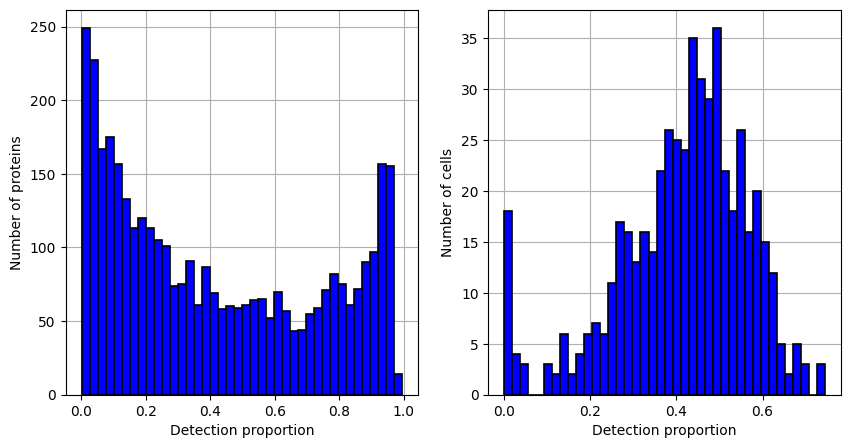

In [6]:
mask = np.isnan(adata.X)

p_protein = (~mask).mean(axis=0)
p_cell = (~mask).mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(p_protein, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(p_cell, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

Let's see if we can decide which annotation is the batch effect.

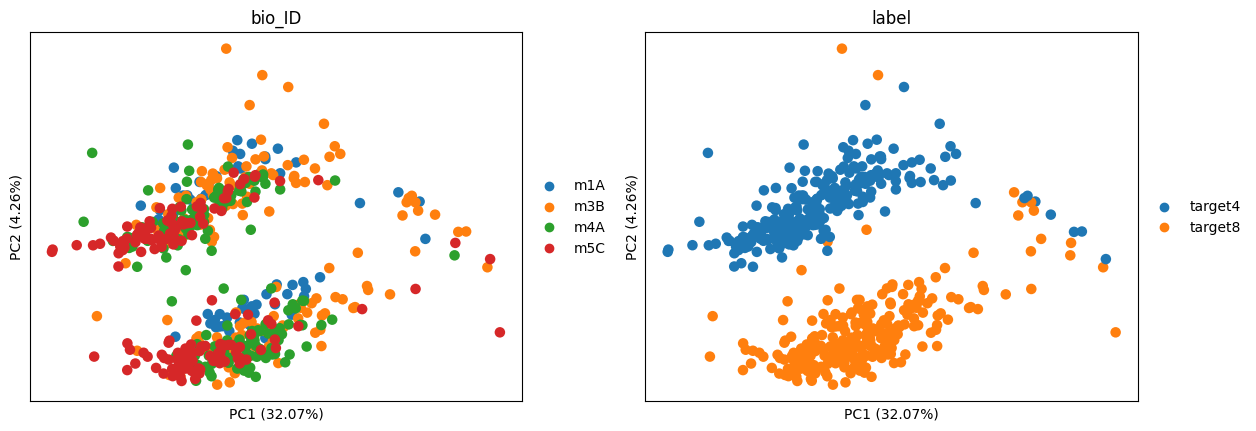

In [7]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["bio_ID", "label"],
    components=["1,2"],
)

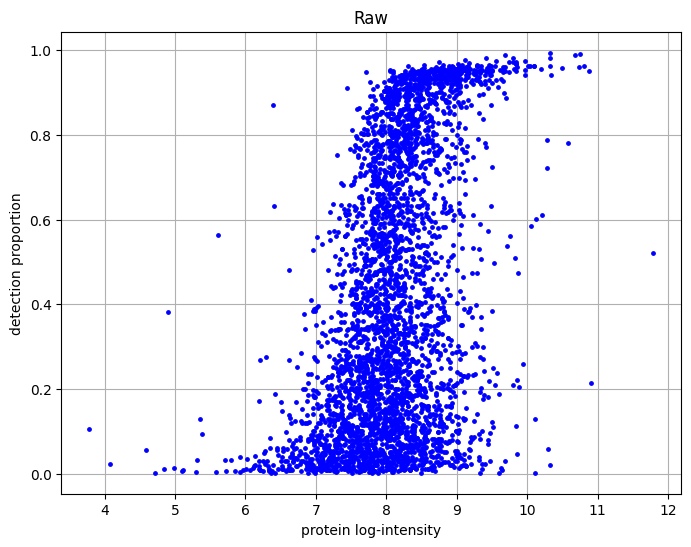

In [8]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="Raw")

## PROTVI

### Training

In [9]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [10]:
PROTVI.setup_anndata(adata, batch_key="label")

model = PROTVI(adata, log_variational=False)
#model.view_anndata_setup()

Let's train the model.

In [11]:
missing_percentage = np.isnan(adata.layers["raw"]).sum() / (adata.shape[0] * adata.shape[1])
model.train(max_epochs=2000, plan_kwargs={"mechanism_weight": missing_percentage}, check_val_every_n_epoch=1)#, plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2000/2000: 100%|██████████| 2000/2000 [05:03<00:00,  7.27it/s, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.87e+3]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [05:03<00:00,  6.59it/s, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.87e+3]


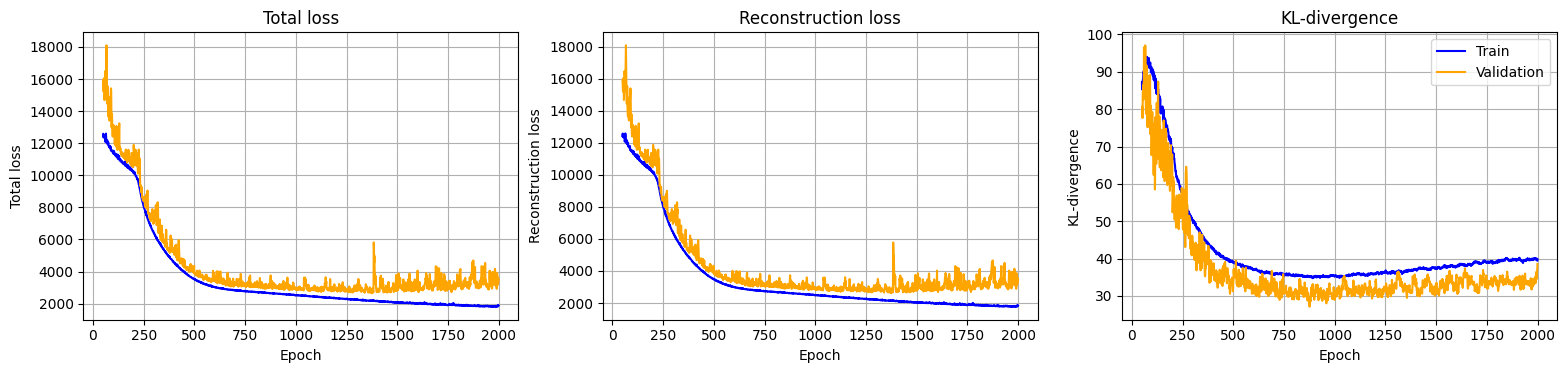

In [15]:
pl.plot_loss(model.history, epoch_start=50)

### Evaluation on training set

In [13]:
x_est, p_est = model.impute()

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

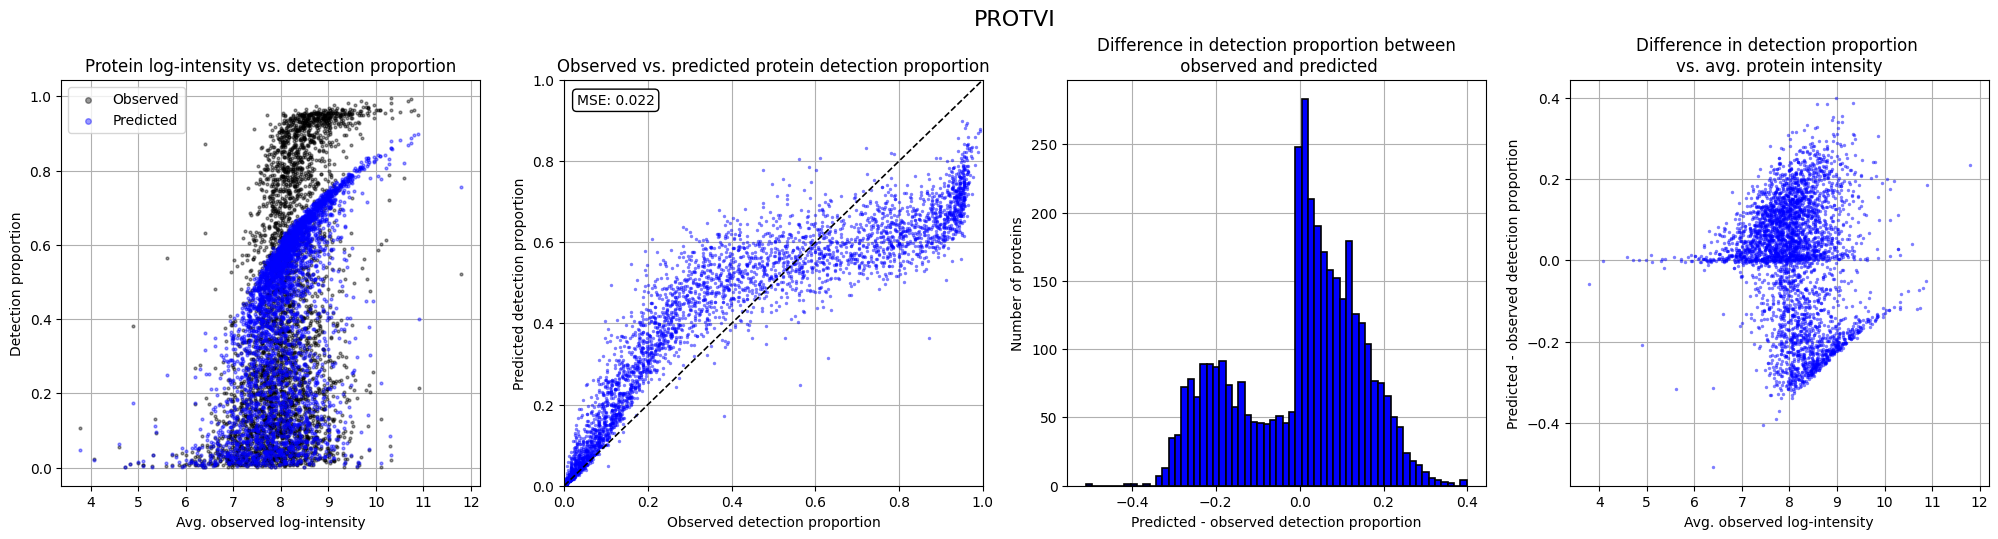

In [16]:
pl.plot_protein_detection_proportion_panel(x_data, p_est)

Let's now compare the protein intensities predicted by the model and the intensities in dataset.

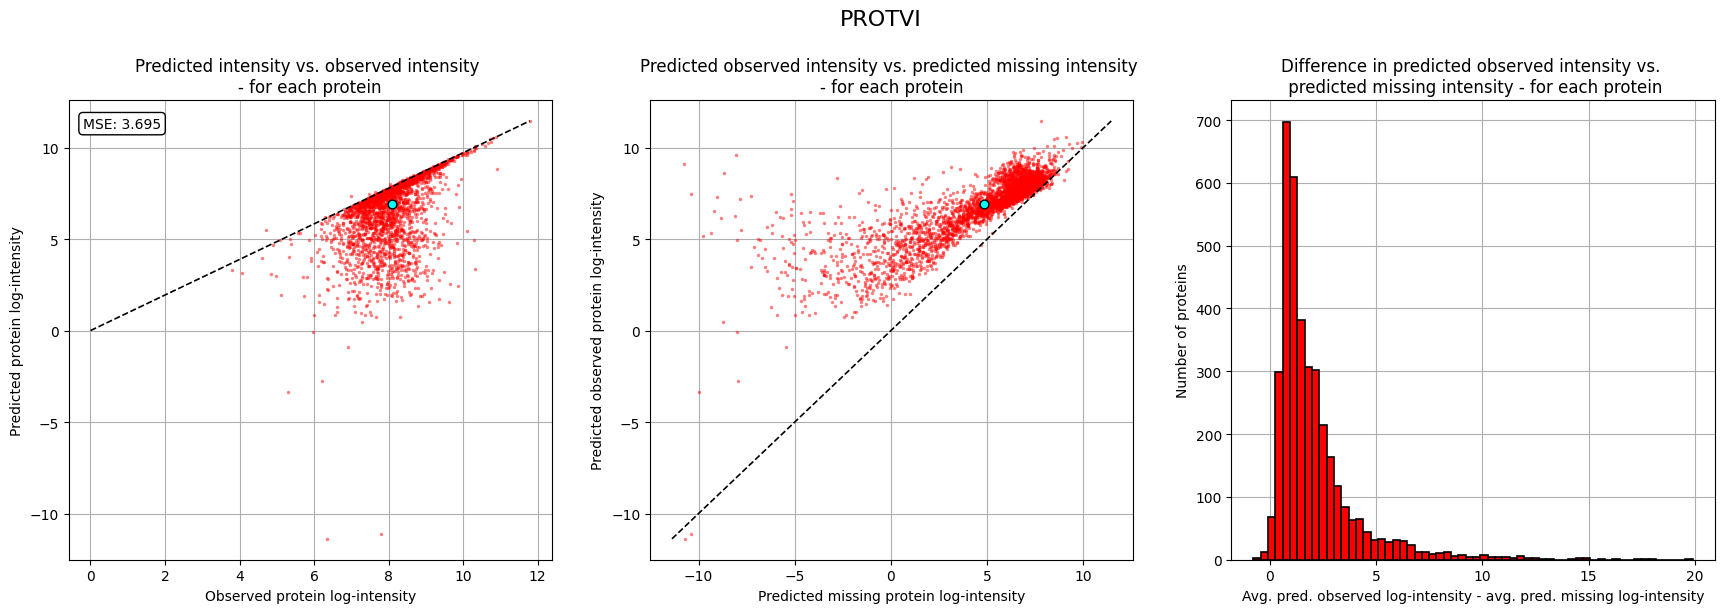

In [18]:
pl.plot_protein_intensity_panel(x_data, x_est)

Let's look at the latent space.

In [19]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

2023-11-27 14:18:56.603244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 14:18:56.603272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 14:18:56.603295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 14:18:57.320278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


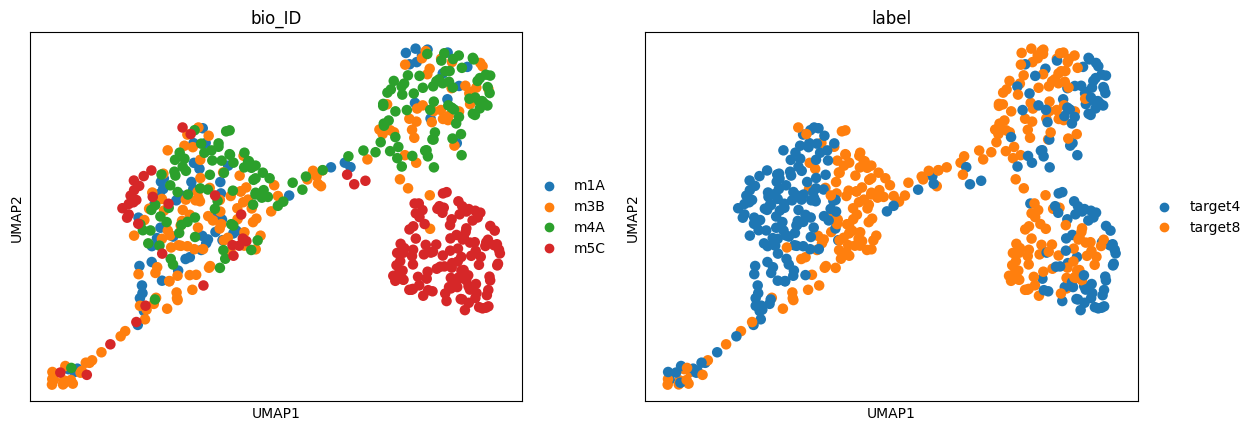

In [20]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["bio_ID", "label"],
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

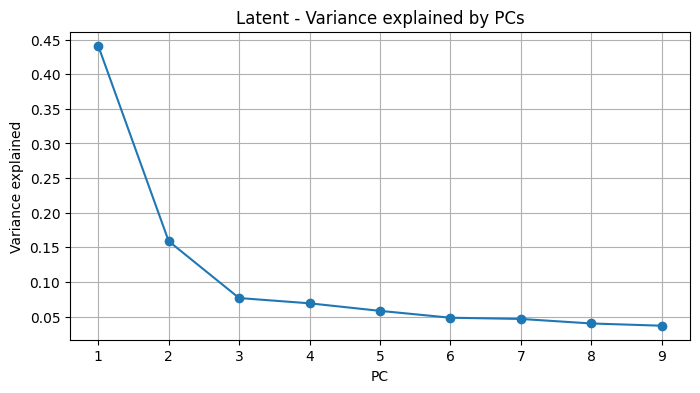

In [21]:
latent_pcs, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, latent_pcs.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_pcs.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title("Latent - Variance explained by PCs")
ax.grid(True)
ax.set_axisbelow(True)

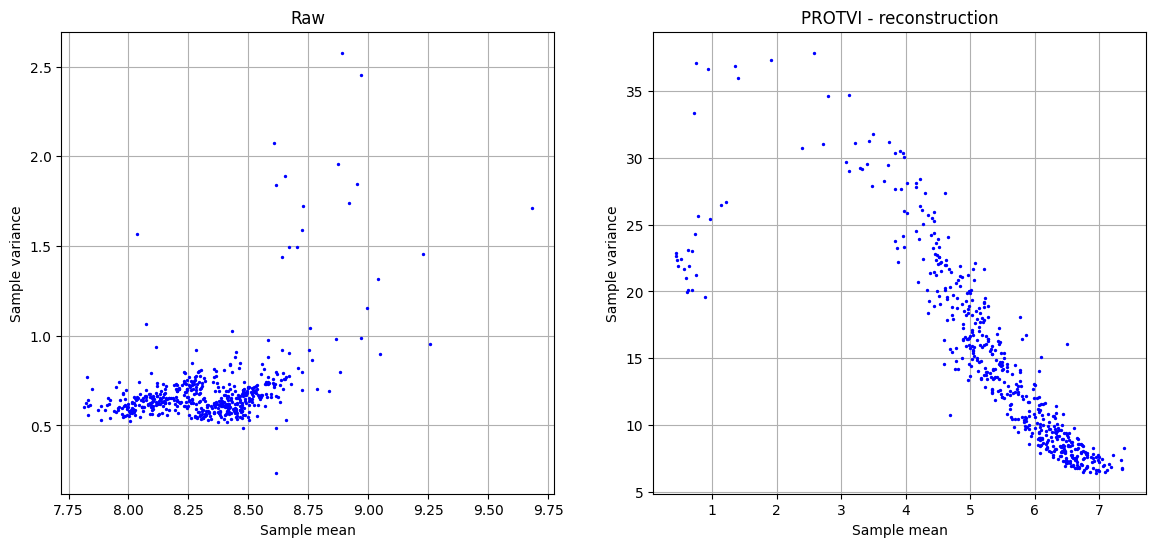

In [22]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["raw"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

First, we'll fit protDP to the data.

In [23]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [24]:
r_adata = utils.prepare_anndata_for_R(adata)

In [25]:
%%R -i r_adata
library(protDP)

X <- assay(r_adata, "raw")
dpcfit <- dpc(X)

In [26]:
protdp_result = robjects.r("dpcfit")

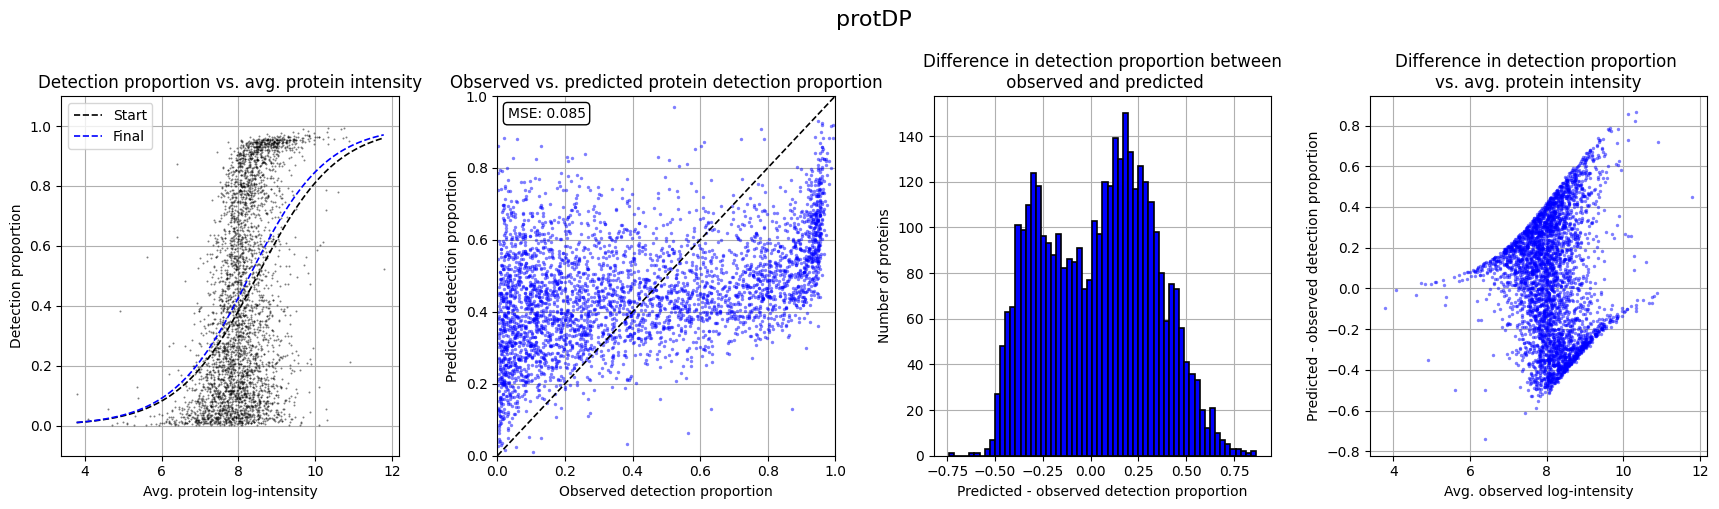

In [28]:
pl.plot_protein_detection_proportion_panel_protDP(x_data, protdp_result)

### protDP vs PROTVI

Let's compare the results of the two methods:

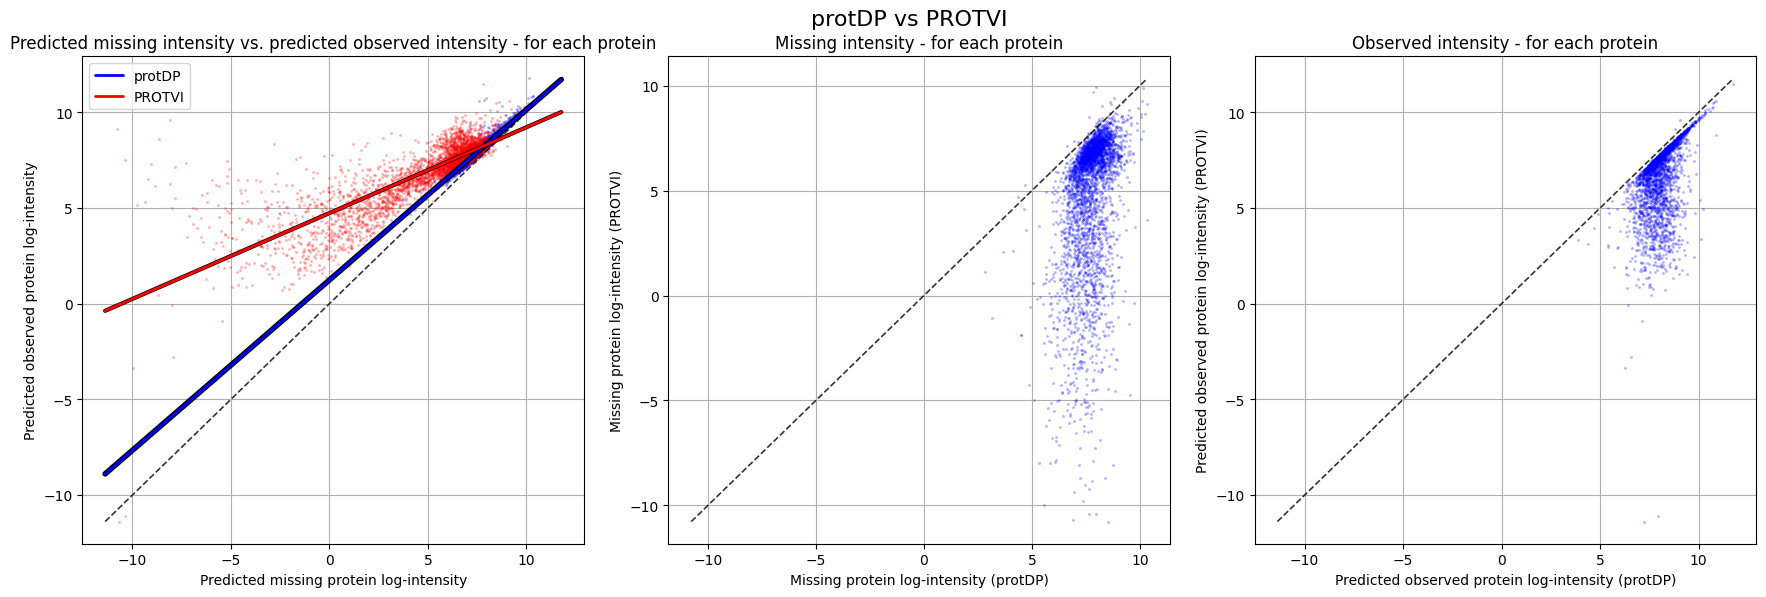

In [29]:
x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

x_est_obs_protein = np.nanmean(x_est_obs, axis=0)
x_est_miss_protein = np.nanmean(x_est_miss, axis=0)

pl.plot_model_intensity_comparison(
    x_data, 
    protdp_result["mu_obs"], 
    protdp_result["mu_mis"],
    x_est_obs_protein, 
    x_est_miss_protein,
    "protDP",
    "PROTVI"
)

In [ ]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_data, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_data), axis=0)
    p_est_protein = p_est.mean(axis=0)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_data, ax=ax)

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()

## Other imputation methods

In [30]:
# @TODO: add for the rest of the imputation methods as well?

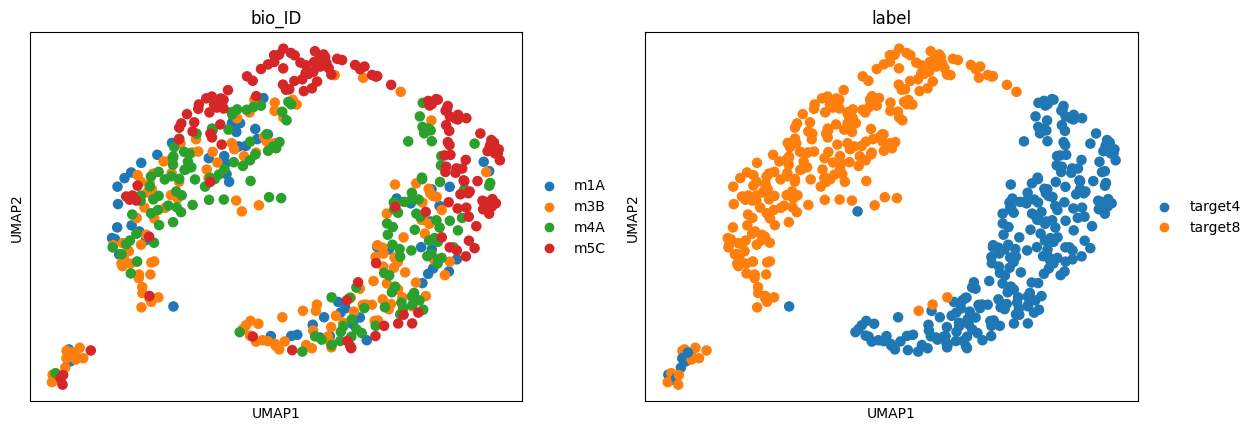

In [31]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["bio_ID", "label"],
)